# Calculating A Tripple

While attempting to code up the distance correlation metric, I ran into a complex sum-expression that had to be calculated. Implementing it in a way that `numpy` and PyTorch understood wasn't straight forward. So this is a bit of a story behind that... and a riff on why mostly I like array programming, but sometimes I really do not.

First the expression. Lets assum we have two lists of numbers, of the same length, `X` and `Y`. We want to calculate the following:

$ \frac{1}{N^3} \sum \limits_{i,j,k}^{N,N,N} |(x_i - x_j)||(y_i - y_k)|$

where $x_i$ and $y_i$ are elements of the distribution $X$ and $Y$, respectively. Note this is a tripple sum - which is why I call it a tripple.

## Discussion

Looking through these, I'd order the ability to understand what is being done (to my eye) in the following order:

1. The math expression above
1. The python version
1. The numba version (which is basically tied with the python version, with a bit more boiler plate)
1. The meshgrid implementation
1. All the rest. I put them all in the same bucket becasue they would all take me significant time to unfold what is happening.

While I'm _ok_ at working with array programming - sums like this are not normal for me. Which might explain why I have trouble with this - but the notation is horrible. The loops are straight forward.

There are of course, other considerations:

1. You can't really differentiate through the loop forms. I tried it with `jax` and... it never finishes for these short distributions of 200. This is may end up being a requirement for all analyses, and it will force everyone to move to this array programing when dealing with distributions like this.
1. The fastest is still the matrix multiplication - by a long shot - even compared to the `numba` compiled code. I'm guessing this is because some short cuts can be taken for the multiplication. Faster, btw, by x10. Which is a lot. I've not looked into that - but there is no reason one couldn't replicate it in `numba`. Of course, that also makes the code harder to read.

In short... array programming reminds me of working with `perl` (often refered to as a write-once language). The `teco` editor as well. I do not know how to make this better given the requirements going forward. But it should sure be nice to find a way.

## Setup

Lets create $X$ and $Y$ as two gaussian distributions.

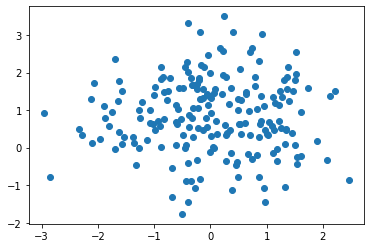

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = np.random.normal(0.0, 1.0, 200)
Y = np.random.normal(1.0, 1.0, 200)

plt.scatter(X, Y)

## Straight Python

This is the most straight forward

In [2]:
def tripple_python(a, b):
    N = len(a)
    s = 0
    for i in range(N):
        for j in range(N):
            t = abs(a[i]-a[j])
            for k in range(N):
                s += t*abs(b[i]-b[k])
    return s/N**3

In [3]:
%timeit tripple_python(X, Y)

4.42 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Obviously, this is not playing ot python's strengths.

## Using Meshgrid

This is the most direct mapping to `numpy` I could think of - create a list of all possible index combinations and then use the `np.take` to pull things appropriately. We also use the `np.mean` to calculate the actual mean.

This has a killer disadvantage which means it can't be used in production: the size of the arrays are $N^3$, which will overwhelm memory if the distirbution is of a decent length. So this is an interesting exercise. But...

In [4]:
def tripple_mesh(a, b):
    all_combo_i, all_combo_j, all_combo_k = np.meshgrid(np.arange(0,len(a)), np.arange(0,len(a)), np.arange(0,len(a)))
    a_i = np.take(a, all_combo_i)
    a_j = np.take(a, all_combo_j)
    b_i = np.take(b, all_combo_i)
    b_k = np.take(b, all_combo_k)
    return np.mean(np.abs((a_i - a_j))*np.abs((b_i - b_k)))

In [5]:
%timeit tripple_mesh(X, Y)

339 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Obviously, much better. If the size gets larger, btw, then some real time gets eaten up in memory allocations - even worse if you force your machine to swap.

## Outer Multiplication plus python

If you stare long enough at the expression, you'll realize that $x_i - x_j$ is actually just the outer join or multiplication. And the $(x_i-x_j)(y_i-y_j)$ is the outter multiplication, row-by-row! So, lets power that by a python loop.

In [6]:
def tripple_outer_python(a,b):
    a_outer = np.abs(np.subtract.outer(a,a))
    b_outer = np.abs(np.subtract.outer(b,b))
    s = 0.0
    for i in range(len(a)):
        m = np.multiply.outer(a_outer[i], b_outer[i])
        s += np.sum(m)
    return s / (len(a)*len(a)*len(a))

In [7]:
%timeit tripple_outer_python(X,Y)

14.4 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


There is a variation on this - using the implicit slicing syntax to do the outer multiplication (sometihng I learned from this exercise):

In [8]:
def tripple_slice_python(a,b):
    a_outer = abs(a[:, None] - a[None, :])
    b_outer = abs(b[:, None] - b[None, :])
    s = 0.0
    for i in range(len(a)):
        m = np.multiply.outer(a_outer[i], b_outer[i])
        s += np.sum(m)
    return s / (len(a)*len(a)*len(a))

In [9]:
%timeit tripple_slice_python(X,Y)

13.1 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It makes very little difference in the speed.

## Outer Multiplicate Twice with Sum

Note that we do the outer multiplicate twice above - so why not do it inline? This idea came from Nick Smith.

It does. however, have a similar problem with the `metshgrid` solution - the temporaries are of size $N^3$, so this can't really be used in production.

In [10]:
def tripple_slice_square_mean(a,b):
    return np.mean(abs(a[:, None] - a[None,:])[:, :, None] * abs(b[:, None] - b[None,:])[:, None, :])

In [11]:
%timeit tripple_slice_square_mean(X, Y)

16.9 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Einstein Sum

Yet another possibilitiy is to use the `einsum` method - which basically uses an Einstein summ. This game from Giordon Stark with some help from Nick Smith.

In [12]:
def tripple_einstein(a,b):
    s = np.einsum("ij,ik->", abs(a[:, None] - a[None, :]), abs(b[:, None] - b[None, :]))
    return s / len(a)**3

In [13]:
%timeit tripple_einstein(X,Y)

6.28 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This was what I neded up using when I moved over to `pytorch`.

## Matrix Multiply

That outer sum, with some tricks, can be turned into a matrix multiply. This is from David Lange.

In [14]:
def tripple_matmul(a,b):
    # Matrix multiply but with Nick's notation triggering the transpose.
    a_outer = abs(a[:, None] - a[None, :])
    b_outer = abs(b[:, None] - b[None, :])
    
    return np.sum(np.matmul(a_outer,b_outer))/(len(a)**3)

In [15]:
%timeit tripple_matmul(X,Y)

519 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


I had wanted to use this in pytorch, as it is the winner, however, it was actually x5 slower there than the `einsum`.

## Numba

Numba will combine and run this. So we should be able to sort-of write python, and get compiled speed.

In [16]:
import numba

@numba.jit(nopython=True)
def tripple_numba(a, b):
    N = len(a)
    s = 0
    for i in range(N):
        for j in range(N):
            t = abs(a[i]-a[j])
            for k in range(N):
                s += t*abs(b[i]-b[k])
    return s/N**3

In [17]:
%timeit tripple_numba(X,Y)

6.95 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


As fast as the second fasted numpy version - still doesn't get as fast as the matrix multiply. I tried to force early compilation, by adding the signature `float64(float64[:], float64[:])`, however, that didn't change the timing on this.

## JAX

JAX is another `jit` capable add-on. And, you can differentiate through it, which is very cool. Lets see how well this works.

In [18]:
import jax
import jax.numpy as jnp

@jax.jit
def tripple_jax(a, b):
    a_outer = jnp.abs(a[:, None] - a[None, :])
    b_outer = jnp.abs(b[:, None] - b[None, :])
    
    return jnp.sum(jnp.matmul(a_outer,b_outer))/(len(a)**3)

In [19]:
j_X = jax.numpy.asarray(X)
j_Y = jax.numpy.asarray(Y)
%timeit tripple_jax(j_X, j_Y).block_until_ready()

465 µs ± 3.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


About the same amount of time as running it in raw `numpy` - which makes some sense as we aren't really doing very much work in python here - so there isn't much to optimize.

It is too bad we can't use the full loop form.